# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'policy_run_1'
experiment_name_dis = 'policy_run_distraction_1'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder_dis = fr'F:\jesse_sim_results\{experiment_name_dis}'
# experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_scenario_dataframe(scenario, columns_of_interest, folder, file, input_file):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # initialise scenario boolean
            row_matches_scenario = False

            # open zip file (remove .csv form file name)
            # try:
            # check whether input file matches this scenario
            # open input zip file
            with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                # read input csv
                with zip_ref.open(input_file) as input_data_file:
                    df_input = pd.read_csv(input_data_file)
                    row_matches_scenario = all(df_input.iloc[0][key] == value for key, value in scenario.items())
                    
            # get data if input values match this scenario
            if row_matches_scenario:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number

                        # broadcast input data to all rows in df_interest
                        for col in df_input.columns:
                            df_interest[col] = df_input[col].iloc[0]
                    
                        # add this data to the main DataFrame
                        df = pd.concat([df, df_interest])
            # except:
            #     print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
# define scenario
scenario_a = {
    'level0_fraction': 0.25,
    'level1_fraction': 0.25,
    'level2_fraction': 0.25,
    'level3_fraction': 0.25,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}

# define scenario
scenario_b = {
    'level0_fraction': 0.25,
    'level1_fraction': 0.25,
    'level2_fraction': 0.25,
    'level3_fraction': 0.25,
    'in_vehicle_distraction': True,
    'road_side_distraction': True
}

scenario_labels = ['Scenario 8', 'Scenario 8 distracted']
scenario_colors = ['steelblue', 'darkorange']

# function to filter a dataframe based on the scenario input values
def filter_dataframe_on_scenario(df, scenario):
    df_filtered = df[
        (df['level0_fraction'] == scenario['level0_fraction']) &
        (df['level1_fraction'] == scenario['level1_fraction']) &
        (df['level2_fraction'] == scenario['level2_fraction']) &
        (df['level3_fraction'] == scenario['level3_fraction']) &
        (df['in_vehicle_distraction'] == scenario['in_vehicle_distraction']) &
        (df['road_side_distraction'] == scenario['road_side_distraction'])
    ]
    return df_filtered

## Traffic performance

### Task saturation and situational awareness

In [6]:
# get saturation data
saturation_variables = ['time', 'x_position', 'task_saturation', 'situational_awareness', 'reaction_time']
df_gtu_saturation_a = load_scenario_dataframe(scenario_a, saturation_variables, experiment_folder, sequence_output, input_values)
df_gtu_saturation_b = load_scenario_dataframe(scenario_b, saturation_variables, experiment_folder_dis, sequence_output, input_values)

In [7]:
# plot mean speed distribution
def show_saturation_distribution(data_list, labels, section_positions, section_labels):
    # define colors for each DataFrame
    colors = ['steelblue', 'darkorange']
    
    # create figure
    plt.figure(figsize=(12, 8))
    
    # width of each individual bar
    bar_width = 20
    num_dfs = len(data_list)
    
    # loop through provided DataFrames
    for i, df in enumerate(data_list):
        # create bins based on x position and calculate the mean speed
        df['x_bin'] = (df['x_position'] // 50) * 50
        mean_speed_per_bin = df.groupby('x_bin')['task_saturation'].mean().reset_index()

        # shift bars horizontally
        x_positions = mean_speed_per_bin['x_bin'] + i * bar_width - (num_dfs * bar_width / 2) + 30

        # plot each bar
        plt.bar(x_positions, mean_speed_per_bin['task_saturation'], width=bar_width, color=colors[i % len(colors)], label=labels[i])

    # custom ticks for section boundaries
    plt.xticks(section_positions, section_labels)
        
    # show plot
    plt.xlabel('Freeway position (100-meter bins)', fontsize=11)
    plt.ylabel('Mean task saturation [-]', fontsize=11)
    plt.title('Mean task saturation per 100-meter segment', fontsize=14)
    plt.legend(title='Scenario')
    plt.show()

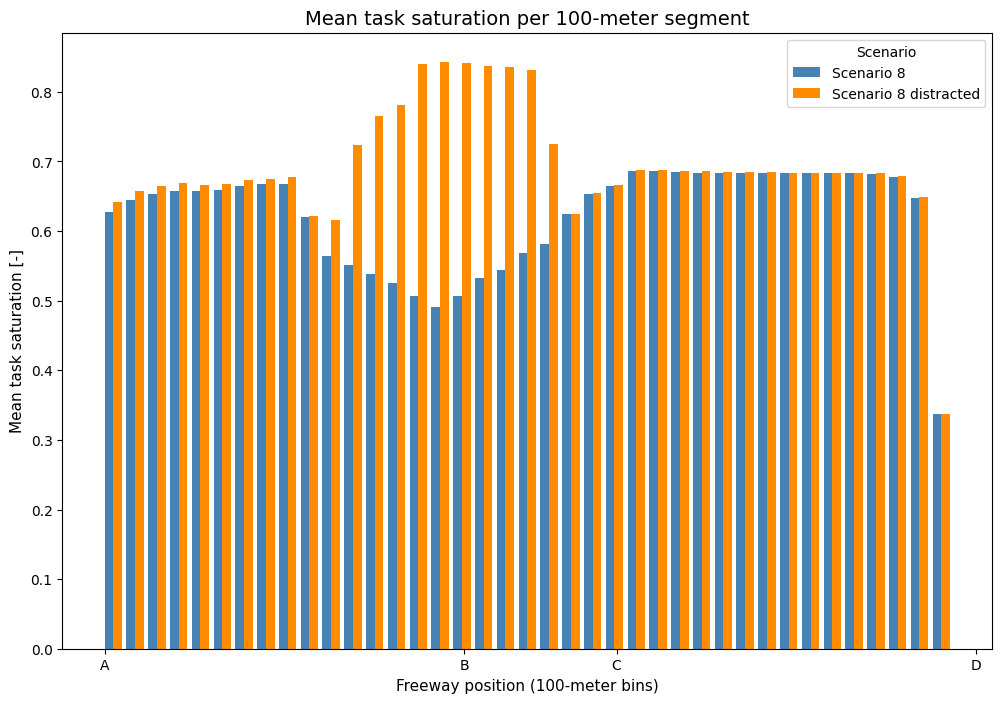

In [8]:
section_pos = [0, 825, 1175, 2000]
sections = ['A', 'B', 'C', 'D']
show_saturation_distribution([df_gtu_saturation_a, df_gtu_saturation_b], scenario_labels, section_pos, sections)

### Speed

In [9]:
# get speed data scenario 1
speed_variables = ['time', 'speed', 'x_position']
df_gtu_speed_a = load_scenario_dataframe(scenario_a, speed_variables, experiment_folder, sequence_output, input_values)
# convert speed to km/h
df_gtu_speed_a['speed'] = df_gtu_speed_a['speed'] * 3.6

# get speed data scenario 2
df_gtu_speed_b = load_scenario_dataframe(scenario_b, speed_variables, experiment_folder_dis, sequence_output, input_values)
# convert speed to km/h
df_gtu_speed_b['speed'] = df_gtu_speed_b['speed'] * 3.6

In [10]:
# plot mean speed distribution
def show_speed_distribution(data_list, labels, section_positions, section_labels):
    # define colors for each DataFrame
    colors = ['steelblue', 'darkorange']
    
    # create figure
    plt.figure(figsize=(12, 8))
    
    # width of each individual bar
    bar_width = 20
    num_dfs = len(data_list)
    
    # loop through provided DataFrames
    for i, df in enumerate(data_list):
        # create bins based on x position and calculate the mean speed
        df['x_bin'] = (df['x_position'] // 50) * 50
        mean_speed_per_bin = df.groupby('x_bin')['speed'].mean().reset_index()

        # shift bars horizontally
        x_positions = mean_speed_per_bin['x_bin'] + i * bar_width - (num_dfs * bar_width / 2) + 30

        # plot each bar
        plt.bar(x_positions, mean_speed_per_bin['speed'], width=bar_width, color=colors[i % len(colors)], label=labels[i])

    # custom ticks for section boundaries
    plt.xticks(section_positions, section_labels)
        
    # show plot
    plt.xlabel('Position (100-meter bins)')
    plt.ylabel('Mean Speed (m/s)')
    plt.title('Mean Speed per 100-meter Segment')
    plt.legend(title='DataFrames')
    plt.show()

# plot mean speed heatmap
def show_speed_heatmap(data_list, labels, section_positions, section_labels):
    # segment length
    segment_length = 25
    
    # define colors for each DataFrame
    cmap = plt.cm.RdYlGn
    norm = plt.Normalize(0, 150)

    # create subplots
    fig, axes = plt.subplots(len(data_list), 1, figsize=(12, 1.2 * len(data_list)), sharex=True)

    # also enable axes[i] if only one dataframe is provided
    if len(data_list) < 2:
        axes = [axes]

    # loop through provided DataFrames
    for i, df in enumerate(data_list):
        # grey background color to represent the road
        axes[i].set_facecolor("lightgrey")
        
        # create bins based on x position and calculate the mean speed
        df['x_bin'] = (df['x_position'] // segment_length) * segment_length
        mean_speed_per_bin = df.groupby('x_bin')['speed'].mean().reset_index()

        # Plot each segment as a colored rectangle with color representing speed
        for _, row in mean_speed_per_bin.iterrows():
            x_start = row['x_bin']
            x_end = x_start + segment_length
            speed = row['speed']
            color = cmap(norm(speed))  # Get color based on speed
            
            # Plot the filled rectangle for the segment
            axes[i].fill_between([x_start, x_end], 0, 1, color=color)
        
        # Set labels and title for each subplot
        axes[i].set_ylabel(labels[i], rotation=0, labelpad=70, fontsize=12)
        axes[i].set_yticks([])  # Hide y-axis ticks to give it a "road" appearance
        axes[i].set_ylim(0, 1)
    
    # Set section labels and positions on the shared x-axis
    plt.xticks(section_positions, section_labels, fontsize=12)
    plt.xlabel('Freeway longitudinal positions', fontsize=12)
    plt.suptitle('Mean speed heatmap along freeway main lanes', fontsize=14)
    
    # Add a colorbar for speed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, orientation='vertical', label='Mean speed (km/h)', aspect=10, pad=0.01)
    cbar.set_label('Mean speed (km/h)', fontsize=11)
    cbar.ax.tick_params(labelsize=11)

    # show plot
    plt.show()

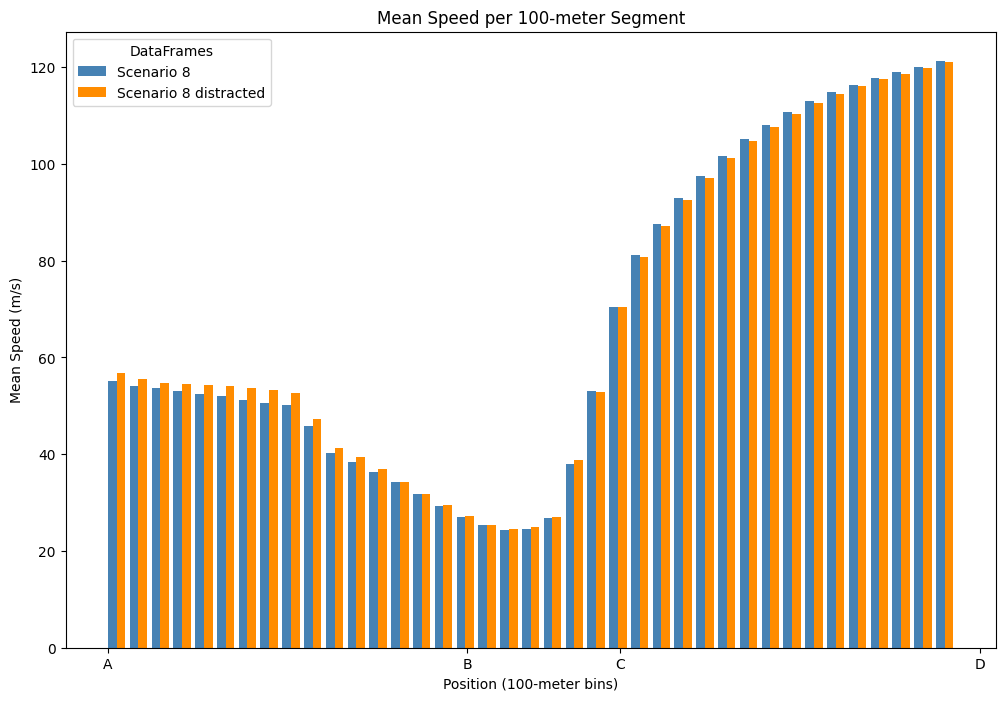

In [11]:
# filter dataframe on road section, do not include on-ramp lanes
# show speed bar plot
section_pos = [0, 825, 1175, 2000]
sections = ['A', 'B', 'C', 'D']
show_speed_distribution([df_gtu_speed_a, df_gtu_speed_b], scenario_labels, section_pos, sections)

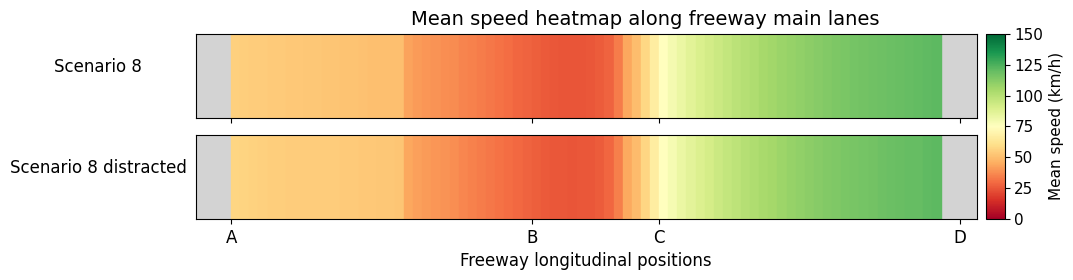

In [12]:
show_speed_heatmap([df_gtu_speed_a, df_gtu_speed_b], scenario_labels, section_pos, sections)

### Travel time

In [13]:
# show travel time boxplots
def plot_travel_times(data_list, labels, colors):
    # Define travel time columns to plot
    travel_time_columns = ['travel_time', 'main_travel_time', 'ramp_travel_time']
    
    # Create figure and subplots for each travel time column
    fig, axes = plt.subplots(1, len(travel_time_columns), figsize=(12, 6), sharey=True)
    fig.suptitle('Travel time comparison', fontsize=14)
    
    # Loop over each travel time column to create a subplot
    for i, col in enumerate(travel_time_columns):
        # Collect data for the current travel time column from each DataFrame
        data_to_plot = [df[col].dropna() for df in data_list]  # Drop NaNs for cleaner boxplots
        
        # Plot the boxplot in the respective subplot
        box = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
        axes[i].set_xlabel(col.capitalize().replace('_', ' '), fontsize=12)
        axes[i].set_ylim(bottom=0)
        if i == 0:
            axes[i].set_ylabel('Travel time (s)', fontsize=12)  # Set y-axis label only once for clarity

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [14]:
# get speed data scenario 1
travel_time_variables = ['travel_time', 'main_travel_time', 'ramp_travel_time']
df_gtu_speed_a = load_scenario_dataframe(scenario_a, travel_time_variables, experiment_folder, intermediate_output, input_values)

# get speed data scenario 2
df_gtu_speed_b = load_scenario_dataframe(scenario_b, travel_time_variables, experiment_folder_dis, intermediate_output, input_values)

C:\Users\jesse\AppData\Local\Temp\ipykernel_20700\3260740722.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\jesse\AppData\Local\Temp\ipykernel_20700\3260740722.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\jesse\AppData\Local\Temp\ipykernel_20700\3260740722.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)


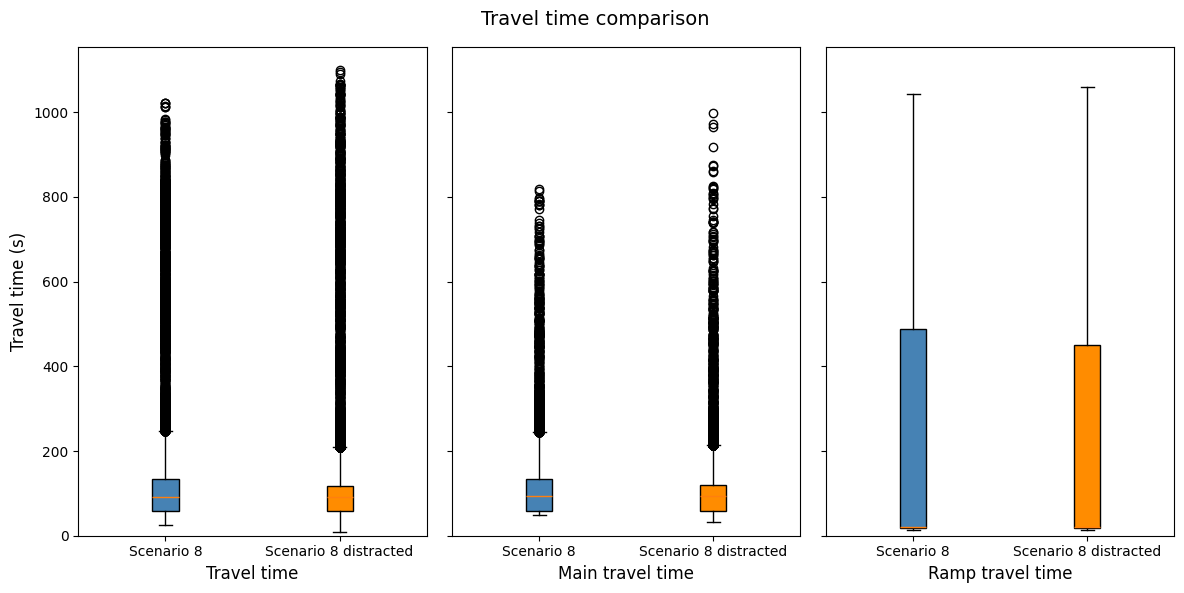

In [15]:
# show travel time data
plot_travel_times([df_gtu_speed_a, df_gtu_speed_b], labels=scenario_labels, colors=scenario_colors)

### Fundamental diagrams

In [16]:
# add time column
def add_time_column(df, sample_interval):
    df['time'] = df.groupby(['seed', 'run']).cumcount() * sample_interval
    return df

# filter columns
def filter_columns(df, selected_variables):
    columns_to_include = [col for col in df.columns if col in selected_variables]
    df = df[columns_to_include]
    return df

# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted

In [17]:
# select merging lanes and required FD variables
variables = ['AB.LEFT_density', 'AB.LEFT_flow', 'AB.LEFT_speed',
             'AB.RIGHT_density', 'AB.RIGHT_flow', 'AB.RIGHT_speed',
             'BC.LEFT_density', 'BC.LEFT_flow', 'BC.LEFT_speed',
             'BC.RIGHT_density', 'BC.RIGHT_flow', 'BC.RIGHT_speed',
             'BC.ONRAMP_density', 'BC.ONRAMP_flow', 'BC.ONRAMP_speed',
             'CD.LEFT_density', 'CD.LEFT_flow', 'CD.LEFT_speed',
             'CD.RIGHT_density', 'CD.RIGHT_flow', 'CD.RIGHT_speed',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow', 'E2B.ONRAMP_speed'
            ]
# scenario 0
# get intermediate FD data
df_fd_a = load_scenario_dataframe(scenario_a, variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd_a = df_fd_a.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd_a = add_time_column(df_fd_a, 30)
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
df_fd_a = filter_columns(df_fd_a, variables_of_interest)

# scenario 1
# get intermediate FD data
df_fd_b = load_scenario_dataframe(scenario_b, variables, experiment_folder_dis, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd_b = df_fd_b.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd_b = add_time_column(df_fd_b, 30)
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
df_fd_b = filter_columns(df_fd_b, variables_of_interest)

In [18]:
# combine road areas
def create_freeway_sections(df):
    df_combined = pd.DataFrame()
    # get run info
    df_combined['time'] = df['time']
    df_combined['main_demand'] = df['main_demand']
    df_combined['ramp_demand'] = df['ramp_demand']
    df_combined['seed'] = df['seed']
    df_combined['run'] = df['run']
    # create AB section (main lanes pre-merging)
    df_combined['AB_flow'] = df['AB.LEFT_flow'] + df['AB.RIGHT_flow']
    df_combined['AB_density'] = (df['AB.LEFT_density'] + df['AB.RIGHT_density']) / 2
    df_combined['AB_speed'] = (df['AB.LEFT_speed'] + df['AB.RIGHT_speed']) / 2
    # create BC section (main lanes + merging lane)
    df_combined['BC_flow'] = df['BC.LEFT_flow'] + df['BC.RIGHT_flow'] + df['BC.ONRAMP_flow']
    df_combined['BC_density'] = (df['BC.LEFT_density'] + df['BC.RIGHT_density'] + df['BC.ONRAMP_density']) / 3
    df_combined['BC_speed'] = (df['BC.LEFT_speed'] + df['BC.RIGHT_speed'] + df['BC.ONRAMP_speed']) / 3
    # create CD section (main lanes post-merging)
    df_combined['CD_flow'] = df['CD.LEFT_flow'] + df['CD.RIGHT_flow']
    df_combined['CD_density'] = (df['CD.LEFT_density'] + df['CD.RIGHT_density']) / 2
    df_combined['CD_speed'] = (df['CD.LEFT_speed'] + df['CD.RIGHT_speed']) / 2
    # also include onramp lane
    df_combined['E2B.ONRAMP_flow'] = df['E2B.ONRAMP_flow']
    df_combined['E2B.ONRAMP_density'] = df['E2B.ONRAMP_density']
    df_combined['E2B.ONRAMP_speed'] = df['E2B.ONRAMP_speed']

    # return DataFrame with combined lanes as road sections
    return df_combined

# create freeway sections and convert units
df_fd_combined_a = create_freeway_sections(df_fd_a)
df_new_fd_a = convert_fd_data(df_fd_combined_a)

df_fd_combined_b = create_freeway_sections(df_fd_b)
df_new_fd_b = convert_fd_data(df_fd_combined_b)

In [19]:
def plot_fd_max_flow(data_list, labels, sections, colors):
    # set bin width
    bin_width = 2
    
    # show plot for each section
    for section in sections:
    
        # create figure
        plt.figure(figsize=(8, 6))
    
        # define columns
        density_col = f'{section}_density'
        flow_col = f'{section}_flow'
    
        # loop through dataframes
        for i, df in enumerate(data_list):
            # calculate max flow for each density bin
            df['density_bin'] = (df[density_col] // bin_width) * bin_width
            max_flow_per_bin = df.groupby('density_bin')[flow_col].max().reset_index()

            # plot max flow points and fill area under the curve
            plt.plot(max_flow_per_bin['density_bin'], max_flow_per_bin[flow_col], label=labels[i], color=colors[i])
            plt.fill_between(max_flow_per_bin['density_bin'], max_flow_per_bin[flow_col], color=colors[i], alpha=0.3)

    # show plot
    # plt.title(f'Fundamental Diagram for section {section}: Max flow per density interval')
    plt.title(f'Freeway section {section}')
    plt.xlabel('Density (veh/km)', fontsize=11)
    plt.ylabel('Max flow (veh/h)', fontsize=11)
    plt.xlim(left=0, right=100)
    plt.ylim(bottom=0, top=5000)
    plt.xticks(np.arange(0, 105, 5))
    plt.yticks(np.arange(0, 6000, 500))
    plt.legend()
    plt.grid(True)
    plt.show()

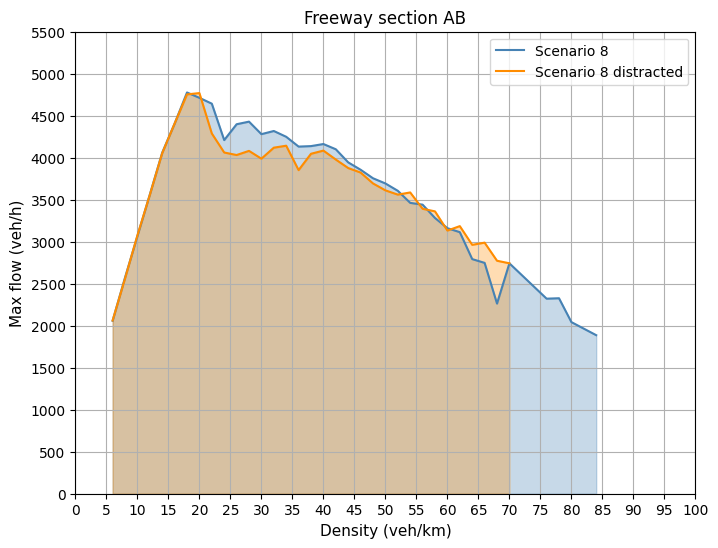

In [20]:
plot_fd_max_flow([df_new_fd_a, df_new_fd_b], scenario_labels, ['AB'], scenario_colors)

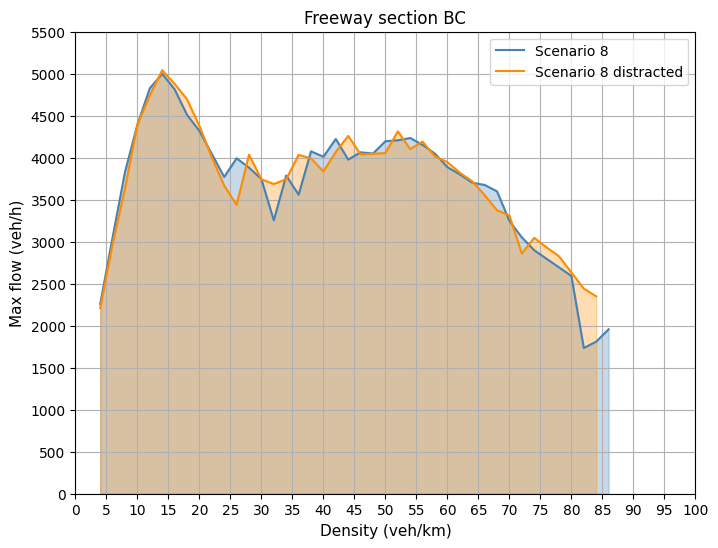

In [21]:
plot_fd_max_flow([df_new_fd_a, df_new_fd_b], scenario_labels, ['BC'], scenario_colors)

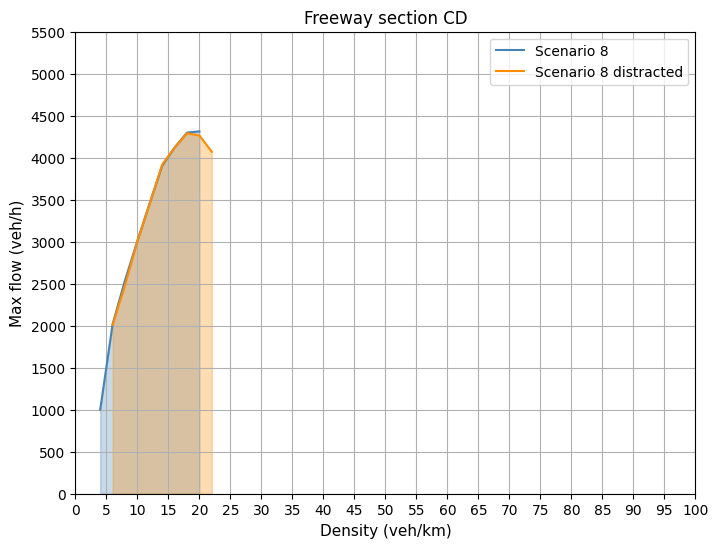

In [22]:
plot_fd_max_flow([df_new_fd_a, df_new_fd_b], scenario_labels, ['CD'], scenario_colors)

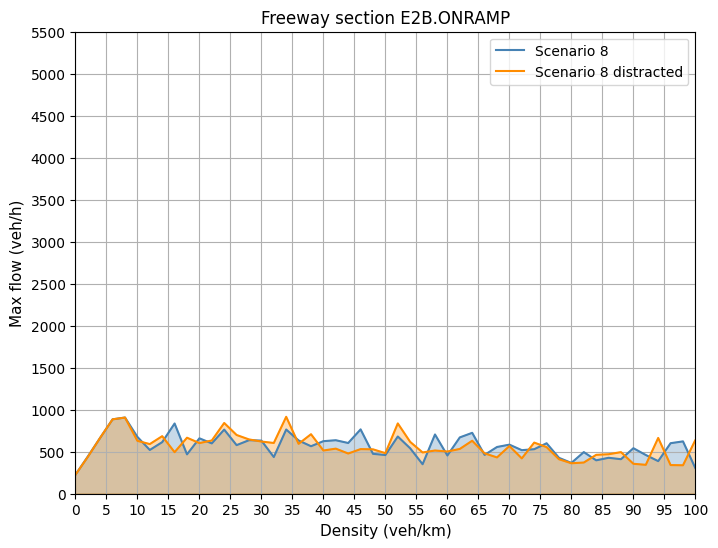

In [23]:
plot_fd_max_flow([df_new_fd_a, df_new_fd_b], scenario_labels, ['E2B.ONRAMP'], scenario_colors)